In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import label_binarize
import seaborn as sns
from itertools import cycle, combinations
from collections import Counter
os.chdir(r"C:\Users\muham\Desktop\YOLOMODEL1")
print(os.getcwd())
Coin = "ETH"

C:\Users\muham\Desktop\YOLOMODEL1


In [2]:
def calculate_average_percentage_change(data):
    percentage_changes = np.diff(data) / data[:-1] * 100
    average_percentage_change = np.mean(percentage_changes)
    
    return average_percentage_change

In [3]:
BEST_COMBINATIONS= {"BNB" : ['BNB_B_L', 'BNB_C_L', 'BNB_G_L', 'BNB_B_X', 'BNB_M_X'], #344

                    "BTC" : ['BTC_C_L', 'BTC_M_L', 'BTC_B_X', 'BTC_C_X'], #240

                    "ETH" : ['ETH_C_L', 'ETH_H_L', 'ETH_M_L', 'ETH_B_X', 'ETH_C_X', 'ETH_M_X'], #745

                    "XRP" : ['XRP_C_L', 'XRP_G_L', 'XRP_M_L', 'XRP_B_X', 'XRP_C_X', 'XRP_G_X']} #728

In [4]:
def MajorityVoting(LabelMatrix, ProbMatrix):

    num_rows = LabelMatrix.shape[0]
    predictions = []

    for i in range(num_rows):
        labels, counts = np.unique(LabelMatrix[i], return_counts=True)
        if len(labels) == 1:
            # Only one unique label, choose it directly
            predicted_label = labels[0]
        else:
            max_count = np.max(counts)
            candidate_labels = labels[counts == max_count]
            if len(candidate_labels) == 1:
                # Only one label with the highest count
                predicted_label = candidate_labels[0]
            else:
                # Multiple labels with the same highest count, check the probabilities
                candidate_probs = [np.mean(ProbMatrix[i][LabelMatrix[i] == label]) for label in candidate_labels]
                predicted_label = candidate_labels[np.argmax(candidate_probs)]

        predictions.append(predicted_label)

    return np.array(predictions)

def CalculateLabelAccuracy(TrueLabels, PredictedLabels):


    classes = np.unique(TrueLabels)
    accuracies = {}

    for cls in classes:

        true_class_indices = TrueLabels == cls
        predicted_class_indices = PredictedLabels == cls
        correct_predictions = np.sum(true_class_indices & predicted_class_indices)
        total_class_samples = np.sum(true_class_indices)
        accuracy = correct_predictions / total_class_samples
        accuracies[cls] = accuracy
    
    
    return accuracies

def ConfusionMatrix(TrueLabels, PredictedLabels, ModelName):

    conf_matrix = confusion_matrix(TrueLabels, PredictedLabels)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_xlabel('Predicted Labels')
    ax[0].set_ylabel('True Labels')
    ax[0].set_title(f'{ModelName} Confusion Matrix')

    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
    ax[1].set_xlabel('Predicted Labels')
    ax[1].set_ylabel('True Labels')
    ax[1].set_title(f'{ModelName} Normalized Confusion Matrix')

    plt.close()
    return fig

In [5]:
PredictedLabelsDf = pd.read_excel(f"6_Evaluation/ResultTest/{Coin}PredictedLabels.xlsx", index_col = "Unnamed: 0").sort_index()
ProbsDf = pd.read_excel(f"6_Evaluation/ResultTest/{Coin}Probs.xlsx", index_col = "Unnamed: 0").sort_index()

PredictedLabelsDf.head(2)

,TrueLabels,ETH_B_L,ETH_C_L,ETH_G_L,ETH_H_L,ETH_M_L,ETH_B_X,ETH_C_X,ETH_G_X,ETH_H_X,ETH_M_X
1,0,0,2,0,0,0,1,0,0,0,0
10,2,2,2,2,2,2,2,2,2,2,2


In [6]:
ProbsDf.head(2)

,ETH_B_L,ETH_C_L,ETH_G_L,ETH_H_L,ETH_M_L,ETH_B_X,ETH_C_X,ETH_G_X,ETH_H_X,ETH_M_X
1,0.690066,0.510349,0.960495,0.646131,0.642348,0.392812,0.494913,0.999940,0.748198,0.937283
10,0.992592,0.996296,0.987296,0.973935,0.437297,0.732574,0.954234,0.862119,0.995732,0.988052


In [7]:
BestCombinationDf = PredictedLabelsDf[["TrueLabels"] + BEST_COMBINATIONS[Coin]]
Plabels = BestCombinationDf.iloc[:,1:].values
Probs = ProbsDf[BEST_COMBINATIONS[Coin]].values

TrueLabels = PredictedLabelsDf["TrueLabels"].values
MajorityVotingLabels = MajorityVoting(Plabels,Probs)
BestCombinationDf["MV"] = MajorityVotingLabels
PredictedLabelsDf["MV"] = MajorityVotingLabels
BestCombinationDf.tail(5)

C:\Users\muham\AppData\Local\Temp\ipykernel_17696\1878957182.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BestCombinationDf["MV"] = MajorityVotingLabels


,TrueLabels,ETH_C_L,ETH_H_L,ETH_M_L,ETH_B_X,ETH_C_X,ETH_M_X,MV
2340,2,2,2,2,2,2,2,2
2359,2,2,2,2,2,2,2,2
2378,0,0,0,1,0,0,0,0
2386,2,2,2,2,2,2,2,2
2389,2,2,2,2,2,2,2,2


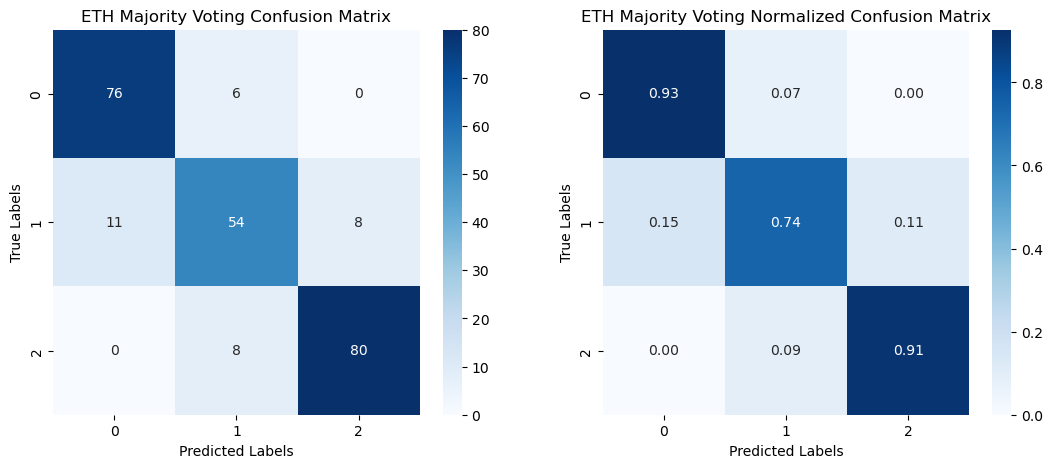

In [8]:
cf = ConfusionMatrix(TrueLabels, MajorityVotingLabels, f"{Coin} Majority Voting" )
cf

In [9]:
overall_accuracy = round(accuracy_score(TrueLabels, MajorityVotingLabels), 2)
overall_precision = round(precision_score(TrueLabels, MajorityVotingLabels, average='micro'),2)
overall_recall = round(recall_score(TrueLabels, MajorityVotingLabels, average='micro'),2)
overall_f1 = round(f1_score(TrueLabels, MajorityVotingLabels, average='micro'),2)

print(Coin)
print("-------------")
print(f"Accuracy: {overall_accuracy}\nPrecision: {overall_precision}\nRecall: {overall_recall}\nF1: {overall_f1}\n" )

ETH
-------------
Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1: 0.86



In [10]:
CalculateLabelAccuracy(TrueLabels, MajorityVotingLabels)

{0: 0.926829268292683, 1: 0.7397260273972602, 2: 0.9090909090909091}

In [11]:
def calculatemetrics(data):
    true_labels = data['TrueLabels']
    

    labels = sorted(true_labels.unique())  
    label_metrics_columns = [f"F1_Label_{label}" for label in labels] + \
                            [f"Rec_Label_{label}" for label in labels] + \
                            [f"Pre_Label_{label}" for label in labels]
   

    df = pd.DataFrame(index=data.columns[1:], 
                      columns=["Model_Acc", "Buy_Acc", "Hold_Acc", "Sell_Acc"] +  ["Model_F1"] + [f"F1_Label_{label}" for label in labels] + 
                               ["Model_Rec"] + [f"Rec_Label_{label}" for label in labels] + ["Model_Pre"] + [f"Pre_Label_{label}" for label in labels])
                               
                               
                               

    for column in data.columns[1:]:
        predicted_labels = data[column]

 
        overall_accuracy = accuracy_score(true_labels, predicted_labels)
        overall_precision = precision_score(true_labels, predicted_labels, average='micro')
        overall_recall = recall_score(true_labels, predicted_labels, average='micro')
        overall_f1 = f1_score(true_labels, predicted_labels, average='micro')


        f1_per_label = f1_score(true_labels, predicted_labels, average=None)
        recall_per_label = recall_score(true_labels, predicted_labels, average=None)
        precision_per_label = precision_score(true_labels, predicted_labels, average=None)


        LA = CalculateLabelAccuracy(true_labels, predicted_labels)
        buyaccuracy = LA[0]
        holdaccuracy = LA[1]
        sellaccuracy = LA[2]


        df.loc[column, "Model_Acc"] = overall_accuracy
        df.loc[column, "Buy_Acc"] = buyaccuracy
        df.loc[column, "Hold_Acc"] = holdaccuracy
        df.loc[column, "Sell_Acc"] = sellaccuracy
        df.loc[column, "Model_F1"] = overall_f1
        df.loc[column, "Model_Rec"] = overall_recall
        df.loc[column, "Model_Pre"] = overall_precision


        for i, label in enumerate(labels):
            df.loc[column, f"F1_Label_{label}"] = f1_per_label[i]
            df.loc[column, f"Rec_Label_{label}"] = recall_per_label[i]
            df.loc[column, f"Pre_Label_{label}"] = precision_per_label[i]

    return df


df = calculatemetrics(PredictedLabelsDf)
df.to_excel(f"{Coin}_ModelPerformance.xlsx")

df


,Model_Acc,Buy_Acc,Hold_Acc,Sell_Acc,Model_F1,F1_Label_0,F1_Label_1,F1_Label_2,Model_Rec,Rec_Label_0,Rec_Label_1,Rec_Label_2,Model_Pre,Pre_Label_0,Pre_Label_1,Pre_Label_2
ETH_B_L,0.786008,0.792683,0.671233,0.875,0.786008,0.807453,0.671233,0.860335,0.786008,0.792683,0.671233,0.875,0.786008,0.822785,0.671233,0.846154
ETH_C_L,0.831276,0.890244,0.684932,0.897727,0.831276,0.863905,0.719424,0.88764,0.831276,0.890244,0.684932,0.897727,0.831276,0.83908,0.757576,0.877778
ETH_G_L,0.773663,0.829268,0.630137,0.840909,0.773663,0.834356,0.638889,0.826816,0.773663,0.829268,0.630137,0.840909,0.773663,0.839506,0.647887,0.813187
ETH_H_L,0.823045,0.865854,0.712329,0.875,0.823045,0.865854,0.707483,0.88,0.823045,0.865854,0.712329,0.875,0.823045,0.865854,0.702703,0.885057
ETH_M_L,0.823045,0.841463,0.753425,0.863636,0.823045,0.851852,0.728477,0.878613,0.823045,0.841463,0.753425,0.863636,0.823045,0.8625,0.705128,0.894118
ETH_B_X,0.82716,0.853659,0.684932,0.920455,0.82716,0.858896,0.70922,0.89011,0.82716,0.853659,0.684932,0.920455,0.82716,0.864198,0.735294,0.861702
ETH_C_X,0.843621,0.902439,0.726027,0.886364,0.843621,0.886228,0.736111,0.891429,0.843621,0.902439,0.726027,0.886364,0.843621,0.870588,0.746479,0.896552
ETH_G_X,0.798354,0.853659,0.684932,0.840909,0.798354,0.843373,0.671141,0.865497,0.798354,0.853659,0.684932,0.840909,0.798354,0.833333,0.657895,0.891566
ETH_H_X,0.790123,0.817073,0.671233,0.863636,0.790123,0.822086,0.662162,0.868571,0.790123,0.817073,0.671233,0.863636,0.790123,0.82716,0.653333,0.873563
ETH_M_X,0.823045,0.902439,0.657534,0.886364,0.823045,0.870588,0.690647,0.881356,0.823045,0.902439,0.657534,0.886364,0.823045,0.840909,0.727273,0.876404


In [12]:
df2 = df.copy()

for col in df.columns:

    minval = 1
    model = "None"

    for row in df.index[:-1]:

        value = df.loc[row, col]
    

        if value < minval:
            minval = value
            model = row

    for row in df.index[:-1]:

        value = df.loc[row, col]

        if value != minval:
            df2.loc[row, col] = "-"
          
df2
    

,Model_Acc,Buy_Acc,Hold_Acc,Sell_Acc,Model_F1,F1_Label_0,F1_Label_1,F1_Label_2,Model_Rec,Rec_Label_0,Rec_Label_1,Rec_Label_2,Model_Pre,Pre_Label_0,Pre_Label_1,Pre_Label_2
ETH_B_L,-,0.792683,-,-,-,0.807453,-,-,-,0.792683,-,-,-,0.822785,-,-
ETH_C_L,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
ETH_G_L,0.773663,-,0.630137,0.840909,0.773663,-,0.638889,0.826816,0.773663,-,0.630137,0.840909,0.773663,-,0.647887,0.813187
ETH_H_L,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
ETH_M_L,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
ETH_B_X,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
ETH_C_X,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
ETH_G_X,-,-,-,0.840909,-,-,-,-,-,-,-,0.840909,-,-,-,-
ETH_H_X,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
ETH_M_X,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


## Generate Result Images

In [13]:
# id = 0

# for labelid, TrueLabelid, PredictedLabelid, dates in zip(LabelIds, TrueLabelIds, PredictedLabelIds, Dates):

#      windowstartid = labelid
#      windowfinishid = labelid + 30 -1

#      CurrentSlopeId = windowfinishid + 15

#      df = ClosePrices.iloc[windowfinishid:CurrentSlopeId+1,:]
#      labeldict = {0:"Buy", 1:"Hold", 2:"Sell"}

#      if TrueLabelid == PredictedLabelid:
#           clr = "blue"
#      else:
#           clr = "red"

#      plt.figure(figsize=(4, 3))
#      plt.bar(df.index, df['Close'], color=clr)
#      plt.xticks([df.index[0], df.index[-1]], rotation=45)
#      plt.xlabel('Date', fontsize = 6, fontweight = "bold")
#      plt.ylabel('Close Price', fontsize = 6, fontweight = "bold")
#      plt.title(f'Window: {Dates[windowstartid]} - {Dates[windowfinishid]}', fontsize = 7, fontweight = "bold")
#      plt.xticks(rotation = 0, fontsize = 6, fontweight = "bold")
#      plt.yticks(fontsize = 6, fontweight = "bold")
     
#      plt.plot([df.index[0], df.index[-1]],  [df['Close'].iloc[0], df['Close'].iloc[-1]],  color='black', linestyle='-', linewidth=1)
     
#      data = df['Close'].values
#      Slope = calculate_average_percentage_change(data)
    
#      plt.text(df.index[-1], df['Close'].iloc[-1], f'μ(Δ%) = {Slope:.2f}', color='black', fontsize=8, ha='center')
#      plt.tight_layout()
#      plt.savefig(f"6_Evaluation/ResultImages/{Coin}/{labelid} - {labeldict[TrueLabelid]} - {labeldict[PredictedLabelid]} ")
#      plt.close()
#      id+=1
   